In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix
import shap
import category_encoders as ce

In [3]:
df = pd.read_csv('hospital_readmissions.csv')
print("Dataset shape:", df.shape)

Dataset shape: (25000, 17)


In [5]:
print(df.head())

       age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 8                72             1             18   
1  [70-80)                 3                34             2             13   
2  [50-60)                 5                45             0             18   
3  [70-80)                 2                36             0             12   
4  [60-70)                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency medical_specialty       diag_1  \
0             2            0            0           Missing  Circulatory   
1             0            0            0             Other        Other   
2             0            0            0           Missing  Circulatory   
3             1            0            0           Missing  Circulatory   
4             0            0            0  InternalMedicine        Other   

        diag_2       diag_3 glucose_test A1Ctest change diabetes_med

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

In [9]:
print(df.describe())

       time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
count       25000.00000       25000.00000  25000.000000   25000.000000   
mean            4.45332          43.24076      1.352360      16.252400   
std             3.00147          19.81862      1.715179       8.060532   
min             1.00000           1.00000      0.000000       1.000000   
25%             2.00000          31.00000      0.000000      11.000000   
50%             4.00000          44.00000      1.000000      15.000000   
75%             6.00000          57.00000      2.000000      20.000000   
max            14.00000         113.00000      6.000000      79.000000   

       n_outpatient   n_inpatient   n_emergency  
count  25000.000000  25000.000000  25000.000000  
mean       0.366400      0.615960      0.186600  
std        1.195478      1.177951      0.885873  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000

Data Cleaning

In [11]:
df.columns = [c.strip().lower() for c in df.columns]

In [13]:
df['readmitted'] = df['readmitted'].str.strip().str.lower()
df['medical_specialty'] = df['medical_specialty'].astype(str).str.strip()
df['age'] = df['age'].astype(str).str.strip()
df['readmit_30'] = df['readmitted'].map(lambda x: 1 if str(x).strip() == 'yes' else 0)

In [15]:
print("Rows:", len(df))
print("Unique readmitted values:", df['readmitted'].unique())
print("Unique specialties:", df['medical_specialty'].nunique())

Rows: 25000
Unique readmitted values: ['no' 'yes']
Unique specialties: 7


EDA

In [17]:
overall_readmission = df['readmitted'].value_counts(normalize=True) * 100
print("\nOverall Readmission Rate (%):\n", overall_readmission)


Overall Readmission Rate (%):
 readmitted
no     52.984
yes    47.016
Name: proportion, dtype: float64


In [19]:
avg_stay = df.groupby('readmitted')['time_in_hospital'].mean()
print("\nAverage Hospital Stay:\n", avg_stay)


Average Hospital Stay:
 readmitted
no     4.331345
yes    4.590778
Name: time_in_hospital, dtype: float64


In [21]:
readmission_by_specialty = df.groupby('medical_specialty')['readmitted'].value_counts(normalize=True).unstack().fillna(0)
readmission_by_specialty = readmission_by_specialty.sort_values(by='yes', ascending=False)
print("\nReadmission Rate by Specialty:\n", readmission_by_specialty.head(10))


Readmission Rate by Specialty:
 readmitted                    no       yes
medical_specialty                         
Family/GeneralPractice  0.504782  0.495218
Emergency/Trauma        0.506101  0.493899
Missing                 0.510903  0.489097
Cardiology              0.550035  0.449965
InternalMedicine        0.552314  0.447686
Other                   0.585210  0.414790
Surgery                 0.587799  0.412201


In [23]:
readmission_by_med = df.groupby('diabetes_med')['readmitted'].value_counts(normalize=True).unstack().fillna(0)
print("\nReadmission Rate by Diabetes Medication:\n", readmission_by_med)


Readmission Rate by Diabetes Medication:
 readmitted          no       yes
diabetes_med                    
no            0.586452  0.413548
yes           0.512846  0.487154


In [25]:
readmission_by_a1c = df.groupby('a1ctest')['readmitted'].value_counts(normalize=True).unstack().fillna(0)
print("\nReadmission Rate by A1C Test Result:\n", readmission_by_a1c)


Readmission Rate by A1C Test Result:
 readmitted        no       yes
a1ctest                       
high        0.540502  0.459498
no          0.525504  0.474496
normal      0.578947  0.421053


In [27]:
readmission_by_diag = df.groupby('diag_1')['readmitted'].value_counts(normalize=True).unstack().fillna(0)
readmission_by_diag = readmission_by_diag.sort_values(by='yes', ascending=False)
print("\nReadmission Rate by Primary Diagnosis:\n", readmission_by_diag.head(10))


Readmission Rate by Primary Diagnosis:
 readmitted             no       yes
diag_1                             
Diabetes         0.463652  0.536348
Missing          0.500000  0.500000
Respiratory      0.509239  0.490761
Circulatory      0.520706  0.479294
Digestive        0.525547  0.474453
Other            0.548784  0.451216
Injury           0.563625  0.436375
Musculoskeletal  0.604633  0.395367


Visualization

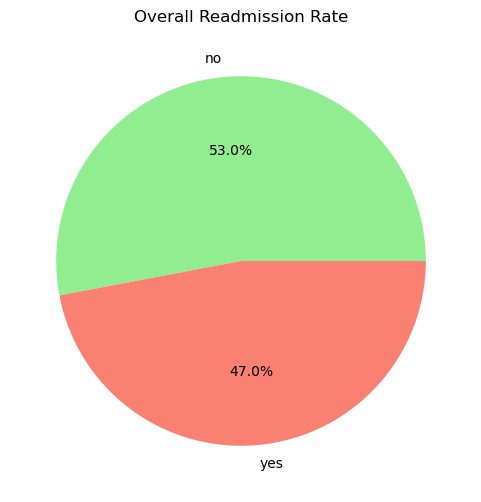

In [29]:
plt.figure(figsize=(6,6))
overall_readmission.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen','salmon'])
plt.title("Overall Readmission Rate")
plt.ylabel('')
plt.show()

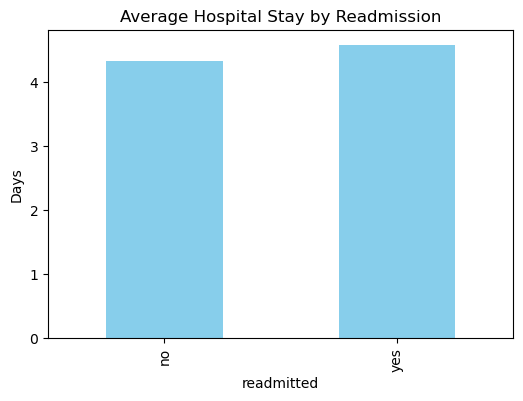

In [31]:
plt.figure(figsize=(6,4))
avg_stay.plot(kind='bar', color='skyblue')
plt.title("Average Hospital Stay by Readmission")
plt.ylabel("Days")
plt.show()

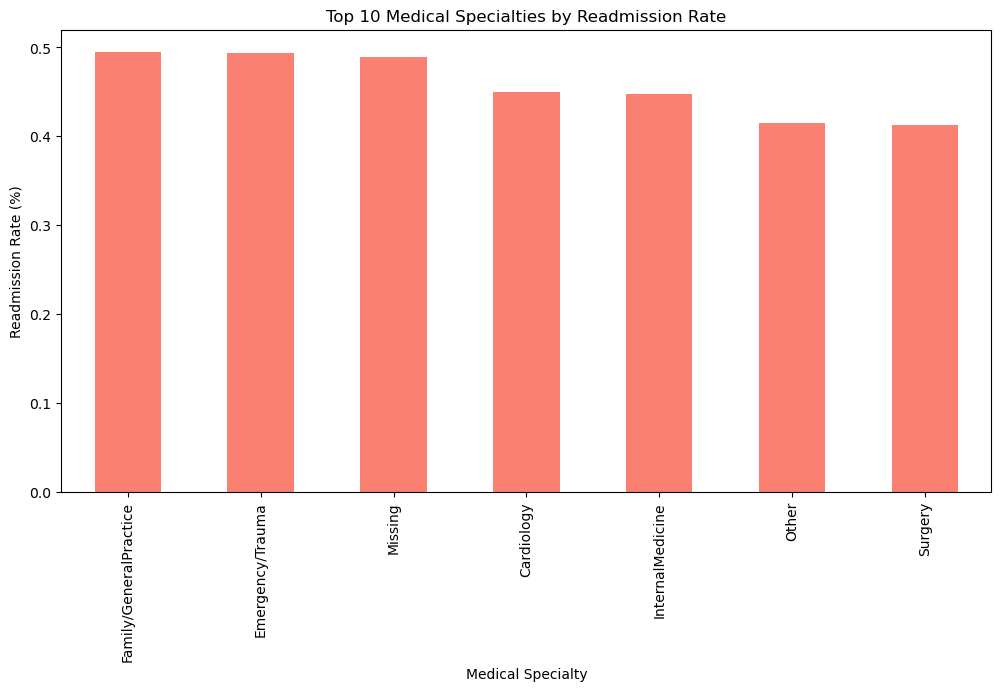

In [33]:
plt.figure(figsize=(12,6))
readmission_by_specialty['yes'].head(10).plot(kind='bar', color='salmon')
plt.title("Top 10 Medical Specialties by Readmission Rate")
plt.ylabel("Readmission Rate (%)")
plt.xlabel("Medical Specialty")
plt.show()

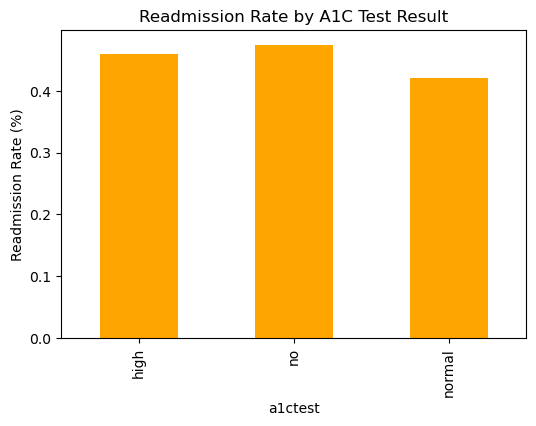

In [35]:
plt.figure(figsize=(6,4))
readmission_by_a1c['yes'].plot(kind='bar', color='orange')
plt.title("Readmission Rate by A1C Test Result")
plt.ylabel("Readmission Rate (%)")
plt.show()

Export tables for PowerBI

In [37]:
readmission_by_specialty.reset_index().to_csv("readmission_by_specialty.csv", index=False)
readmission_by_med.reset_index().to_csv("readmission_by_medication.csv", index=False)
readmission_by_a1c.reset_index().to_csv("readmission_by_a1c.csv", index=False)
readmission_by_diag.reset_index().to_csv("readmission_by_diag.csv", index=False)
print("\n CSV files exported for Power BI dashboards")


 CSV files exported for Power BI dashboards


ML Model Pipeline

In [39]:
numeric_cols = ['time_in_hospital','n_procedures','n_lab_procedures','n_medications','n_outpatient','n_inpatient','n_emergency']
cat_features = [c for c in ['age','medical_specialty','diag_1','diag_2','diag_3','glucose_test','a1ctest','change','diabetes_med'] if c in df.columns]
num_features = [c for c in numeric_cols if c in df.columns]

In [51]:
for c in cat_features:
    df[c] = df[c].fillna('Missing').astype(str)

X = df[cat_features + num_features].copy()
y = df['readmit_30'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

In [59]:
rf_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=300, 
        random_state=42, 
        class_weight='balanced', 
        n_jobs=-1
    ))
])

print("\nFitting baseline RandomForest...")
rf_pipeline.fit(X_train, y_train)

y_proba = rf_pipeline.predict_proba(X_test)[:, 1]
print("Baseline RF ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))

y_pred = (y_proba >= 0.5).astype(int)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("Baseline PR AUC:", round(pr_auc, 4))



Fitting baseline RandomForest...
Baseline RF ROC AUC: 0.6384
Classification report:
               precision    recall  f1-score   support

           0       0.62      0.69      0.65      2649
           1       0.59      0.52      0.55      2351

    accuracy                           0.61      5000
   macro avg       0.60      0.60      0.60      5000
weighted avg       0.61      0.61      0.60      5000

Confusion matrix:
 [[1819  830]
 [1136 1215]]
Baseline PR AUC: 0.605


Hyperparameter tuning

In [61]:
param_grid = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [8, 16, None],
    'clf__min_samples_leaf': [1, 5]
}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
gs = GridSearchCV(rf_pipeline, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
print("Starting grid search (this may take a while)...")
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)

Starting grid search (this may take a while)...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best params: {'clf__max_depth': 16, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 400}


In [63]:
best_rf = gs.best_estimator_
y_proba_best = best_rf.predict_proba(X_test)[:,1]
print("Tuned RF Test ROC AUC:", round(roc_auc_score(y_test, y_proba_best),4))
y_pred_best = (y_proba_best >= 0.5).astype(int)
print("Tuned classification report:\n", classification_report(y_test, y_pred_best))

Tuned RF Test ROC AUC: 0.6551
Tuned classification report:
               precision    recall  f1-score   support

           0       0.63      0.67      0.65      2649
           1       0.60      0.56      0.58      2351

    accuracy                           0.62      5000
   macro avg       0.62      0.62      0.62      5000
weighted avg       0.62      0.62      0.62      5000



In [65]:
joblib.dump(best_rf, 'best_rf_readmit_corrected.pkl')

['best_rf_readmit_corrected.pkl']

Feature Importance + SHAP

In [67]:
num_names = num_features
try:
    ohe = best_rf.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
    ohe_names = list(ohe.get_feature_names_out(cat_features))
except Exception:
    ohe_names = []
feature_names = list(num_names) + ohe_names
print("Number of features after preprocessing:", len(feature_names))

Number of features after preprocessing: 54


In [69]:
clf = best_rf.named_steps['clf']
if hasattr(clf, "feature_importances_") and feature_names:
    importances = clf.feature_importances_
    fi = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(40)
    fi.to_csv('feature_importance_top40.csv', index=False)
    print("Top 20 features:\n", fi.head(20))
else:
    print("Feature importances not available.")

Top 20 features:
                       feature  importance
5                 n_inpatient    0.158165
2            n_lab_procedures    0.114681
3               n_medications    0.107042
0            time_in_hospital    0.069403
4                n_outpatient    0.052354
1                n_procedures    0.048793
6                 n_emergency    0.037916
34               diag_2_Other    0.017919
42               diag_3_Other    0.017264
17  medical_specialty_Missing    0.017072
36         diag_3_Circulatory    0.016601
28         diag_2_Circulatory    0.016535
26               diag_1_Other    0.015688
10                age_[70-80)    0.015498
20         diag_1_Circulatory    0.015360
11                age_[80-90)    0.014239
8                 age_[50-60)    0.013847
9                 age_[60-70)    0.013217
37            diag_3_Diabetes    0.012136
51                 change_yes    0.011684


In [71]:
X_test_prep = best_rf.named_steps['preproc'].transform(X_test)
tree_model = best_rf.named_steps['clf']
print("Computing SHAP values (may take some time)...")

Computing SHAP values (may take some time)...


In [73]:
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test_prep)
try:
    shap_vals_pos = shap_values[1] if isinstance(shap_values, list) else shap_values
    shap.summary_plot(shap_vals_pos, X_test_prep, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig('shap_summary.png', dpi=200)
    plt.close()
    print("Saved shap_summary.png")
except Exception as e:
    print("Could not create SHAP plot:", e)

Saved shap_summary.png


<Figure size 640x480 with 0 Axes>

Dashboard table for Power BI

In [81]:
if isinstance(shap_values, list):
    shap_vals_pos = shap_values[1]
else:
    if shap_values.ndim == 3 and shap_values.shape[-1] == 2:
        shap_vals_pos = shap_values[:, :, 1]
    else:
        shap_vals_pos = shap_values

In [97]:
shap_df = pd.DataFrame(shap_vals_pos, columns=feature_names, index=X_test.index)
def top_k_contribs(shap_row, k=3):
    absvals = shap_row.abs()
    topk = absvals.nlargest(k).index.tolist()
    return topk, shap_row[topk].values.tolist()

top_feats = shap_df.apply(lambda r: top_k_contribs(r, k=3), axis=1)
top_feats_df = pd.DataFrame(top_feats.tolist(), index=shap_df.index, columns=['top_feats','top_vals'])
top_feats_df[['top1','top2','top3']] = pd.DataFrame(top_feats_df['top_feats'].tolist(), index=top_feats_df.index)
top_feats_df[['top1_val','top2_val','top3_val']] = pd.DataFrame(top_feats_df['top_vals'].tolist(), index=top_feats_df.index)

X_test_out = X_test.copy().reset_index(drop=True)
X_test_out['pred_readmit_prob'] = y_proba_best
X_test_out['pred_readmit_flag'] = (X_test_out['pred_readmit_prob'] >= 0.5).astype(int)
X_test_out['actual_readmit'] = y_test.reset_index(drop=True)

top_feats_df = top_feats_df.reset_index(drop=True)
dashboard_table = pd.concat([X_test_out, top_feats_df[['top1','top1_val','top2','top2_val','top3','top3_val']]], axis=1)
dashboard_table.to_csv('dashboard_table.csv', index=False)
print("Saved dashboard_table.csv – ready for Power BI")

Saved dashboard_table.csv – ready for Power BI


In [99]:
print("\n Pipeline complete. Files generated:")
print("  - best_rf_readmit_corrected.pkl")
print("  - feature_importance_top40.csv")
print("  - shap_summary.png")
print("  - dashboard_table.csv")
print("  - readmission_by_specialty.csv, etc. for Power BI")


 Pipeline complete. Files generated:
  - best_rf_readmit_corrected.pkl
  - feature_importance_top40.csv
  - shap_summary.png
  - dashboard_table.csv
  - readmission_by_specialty.csv, etc. for Power BI
